In [5]:
import pandas as pd 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
data_df = pd.read_csv("final_data/averages.csv", index_col=0)

data_df = data_df.dropna()

betting = pd.read_csv("final_data/betting.csv")

In [7]:
removed_columns = ["season", "date", "won", "target", "team", "team_opp"]
selected_columns = data_df.columns[~data_df.columns.isin(removed_columns)]


scaler = MinMaxScaler()
data_df[selected_columns] = scaler.fit_transform(data_df[selected_columns])

In [8]:
data_df_train_val = data_df[data_df.season != 2022]

target_train_val = data_df.target

data_df_test = data_df[data_df.season == 2022]

target_test = data_df_test.target

betting_test = betting[betting.season == 2022]

In [9]:
model = SVC(probability=True)

In [10]:
split = TimeSeriesSplit(n_splits=6)

sfs = SequentialFeatureSelector(model, 
                                n_features_to_select=15, 
                                direction="forward",
                                cv=split,
                                n_jobs=1,
                                scoring='accuracy'
                               )

In [26]:
sfs.fit(data_df_train_val[selected_columns], data_df_train_val["target"])

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
                          estimator=SVC(probability=True),
                          n_features_to_select=15, n_jobs=1,
                          scoring='accuracy')

In [27]:
predictors = list(selected_columns[sfs.get_support()])

In [42]:
predictors

['stl%',
 'tov%',
 'orb_max',
 '+/-_max',
 'stl%_max',
 '3p_opp',
 'trb_opp',
 'pts_opp',
 'ortg_opp',
 'drb_max_opp',
 'trb_max_opp',
 'blk_max_opp',
 'orb%_max_opp',
 'blk%_max_opp',
 'ortg_max_opp']

In [2]:
# predictors = ['stl%',
#  'tov%',
#  'orb_max',
#  '+/-_max',
#  'stl%_max',
#  '3p_opp',
#  'trb_opp',
#  'pts_opp',
#  'ortg_opp',
#  'drb_max_opp',
#  'trb_max_opp',
#  'blk_max_opp',
#  'orb%_max_opp',
#  'blk%_max_opp',
#  'ortg_max_opp']

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
parameters = {'kernel':['linear', 'rbf'], 'C':[0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1]}
grid_search = GridSearchCV(estimator=model, param_grid=parameters)
grid_search.fit(data_df_train_val[predictors], data_df_train_val["target"])

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['linear', 'rbf']})

In [13]:
model_fitted = grid_search.best_estimator_
print(grid_search.best_params_)

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [14]:
all_results = grid_search.cv_results_
for i in range(len(all_results['params'])):
    print(f"Parameters: {all_results['params'][i]}")
    print(f"Mean Test Score: {all_results['mean_test_score'][i]:.2f}")

Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mean Test Score: 0.58
Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Test Score: 0.62
Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
Mean Test Score: 0.58
Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Test Score: 0.58
Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Mean Test Score: 0.58
Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Mean Test Score: 0.58
Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Mean Test Score: 0.58
Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Mean Test Score: 0.60
Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Mean Test Score: 0.63
Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean Test Score: 0.64
Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
Mean Test Score: 0.63
Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean Test Score: 0.59
Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}

In [15]:
# Evaluate on the test set
test_predictions = model_fitted.predict(data_df_test[predictors])
test_accuracy = accuracy_score(target_test, test_predictions)

print(f"Final Test Accuracy on 2022 season: {test_accuracy:.2f}")

Final Test Accuracy on 2022 season: 0.59


In [16]:
def moneyline_to_decimal(moneyline):
    if moneyline > 0:
        return (moneyline / 100) + 1
    else:
        return (100 / abs(moneyline)) + 1

In [17]:
def calculate_return(moneyline_odds, bet_amount):
    if moneyline_odds > 0:
        return bet_amount * (moneyline_odds / 100) + bet_amount
    else:
        return bet_amount * (100 / abs(moneyline_odds)) + bet_amount

In [18]:
def backtest(data, betting, target, model, predictors):

    principal = 1000 

    principal_over_time = [principal]

    for (i,data_row),(j,betting_row), (k, target) in zip(data[predictors].iterrows(), betting.iterrows(), target.items()):

        home_decimal_odds = moneyline_to_decimal(betting_row["HomeML"])

        away_decimal_odds = moneyline_to_decimal(betting_row["AwayML"])

        prediction_row = pd.DataFrame(data_row).T
    
        home_or_away = model.predict(prediction_row)

        away_prob,home_prob = model.predict_proba(prediction_row)[0]

        if home_or_away == 1:
            bet = principal*(home_prob - away_prob/home_decimal_odds)

            odds = home_decimal_odds

            predicted_prob = home_prob
        else:
            bet = principal*(away_prob - home_prob/away_decimal_odds)

            odds = away_decimal_odds

            predicted_prob = away_prob
        
        principal -= bet

        if home_or_away == target:
            principal += calculate_return(odds, bet)
        
        principal_over_time.append(principal)
    
    return principal_over_time

In [19]:
principal_over_time = backtest(data_df_test, betting_test, target_test, model_fitted, predictors)

In [20]:
import seaborn as sns

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

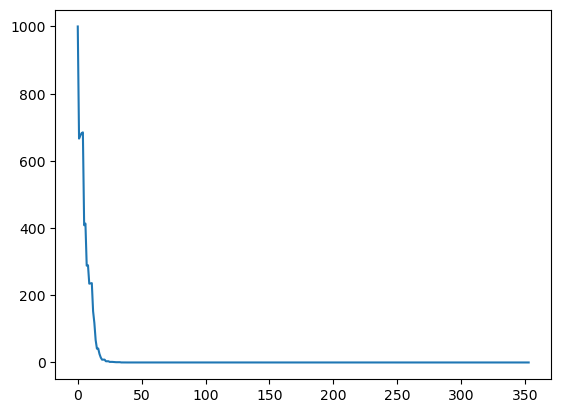

In [21]:
sns.lineplot(x=range(len(principal_over_time)), y=principal_over_time)